# These are the ongoing task so we keep track of it:
    - Join in a single dataframe the audio length distributions
    - Look for patterns in possible features
        - length?
        - mean/median word lenght?
        - punctuation density?
        

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

#Once nobody should be compeled to strain their eyes trying to to understand graphs
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [108]:
treino = pd.read_csv('train.csv',index_col='id')
teste = pd.read_csv('test.csv',index_col='id')

Xtrain = treino[['comment_text']]
ytrain = treino[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']]

Xtest = teste[['comment_text']]
labels = ytrain.columns.to_list()

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [45]:
treino.sample(4)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
54b7494e1cca072a,I had a go at this. I added a banner shell to ...,0,0,0,0,0,0
3f5f7eac12fd519a,""", 24 November 2011 (UTC)\n\nMy apology if you...",0,0,0,0,0,0
660239cdbc31a20f,"What if CISPA bill became DNSchanger virus, Go...",0,0,0,0,0,0
0c03a73f401671eb,I can verify that this is the same guy who was...,0,0,0,0,0,0


In [4]:
teste.sample(4)

,comment_text
id,
12fadbdae593ffd7,""" \n\n So is the libertarian point of view """"f..."
48c1ee90e7038abf,""" \n :::::::::::I'm sorry, I don't see """"we ad..."
5e6a02bc9343cf7a,""" \n\n == Stupidity Running Wildly Out of Cont..."
559bc780e9633057,== Your girlfriend == \n\n She moaned like a w...


In [5]:
ytrain.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
ytrain.apply(pd.value_counts,axis=0)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


We do have an imbalance datset in both ways:
    - within each label - class 1/class 0 ratios for each label -i.e. ratio of 1 to 0 class;
    - between labels - class 1 from different labels - i.e. threat : 478 toxic : 15294;

Train distribution of text length:
 count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64


Test distribution of text length:
 count    153164.000000
mean        364.875121
std         592.492099
min           1.000000
25%          79.000000
50%         180.000000
75%         392.000000
max        5000.000000
Name: comment_text, dtype: float64


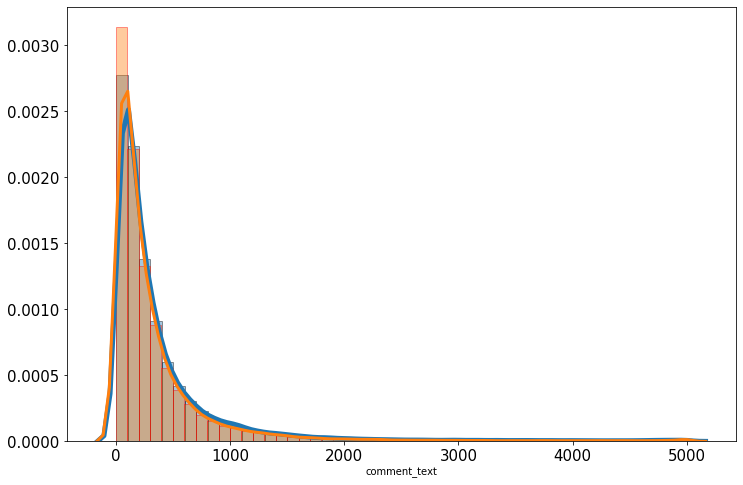

In [7]:
plt.figure(figsize=(12,8));
sns.distplot(Xtrain['comment_text'].apply(len),
    hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 5})
sns.distplot(Xtest['comment_text'].apply(len),
    hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 3})

print('Train distribution of text length:\n',
      Xtrain['comment_text'].apply(len).describe())
print('\n')
print('Test distribution of text length:\n',
      Xtest['comment_text'].apply(len).describe())


- The distribution of twitter lenghts are slightly different between train and test set.

- We will try to understand the frequency of co-occurence/ strenght of association between different labels, which may lead our future modelling.
    - Considering we do have binary classes we will opt for 'Spearman rho', as a non-parametric measure for correlation;

(6.0, 0.0)

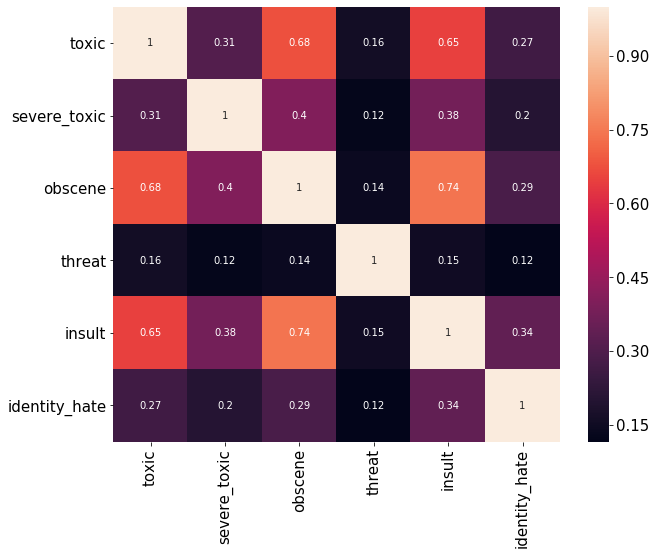

In [8]:
plt.figure(figsize=(10,8))

ax = sns.heatmap(ytrain.corr(method='spearman'),
                 xticklabels=ytrain.columns.values,
                 yticklabels=ytrain.columns.values,
                 annot=True)
bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5) # quick-fix for matplolib 3.1.1 breaking seaborn

- It seems we do have stronger correlations between toxic-obscene, toxic-insult, obscene-insult.
- Interesting to observe that threat do no represent strong correlation.
    - Would that be the case that threateners usually focus their energy mainly on the threat?
    - Or the case that multi-labelling threating altogether with different labels would be difficult?
    

In [9]:
treino_ = treino.copy()
treino_['Length'] = Xtrain['comment_text'].apply(len)

In [10]:
pd.concat([ytrain,treino_['Length']],axis=1).corr()['Length']

toxic           -0.054470
severe_toxic     0.010131
obscene         -0.042945
threat          -0.008011
insult          -0.045052
identity_hate   -0.013647
Length           1.000000
Name: Length, dtype: float64

- Overall it seems that the correlations between the ocurrence (class 1) of certains labels is not strongly correlated to text lenght.
- However checking median  text lenght for each group. We're looking for a bit more robust estimator of central tendency, so forget about the mean.

In [11]:
dict_df = {i:pd.concat([ytrain,treino_['Length']],axis=1).groupby(i)\
    ['Length'].agg(['count','min','max','median','std']) for i in treino_.columns[1:-1]}


In [12]:
lengths = pd.DataFrame()
for k,v in dict_df.items():
    lengths = pd.concat([lengths,v])

lengths.index = pd.MultiIndex.from_product([dict_df.keys(), [0,1]])
lengths.style.background_gradient(cmap='summer_r')

[CLUE]- It seems that it could be quite useful to add a text_length variable from the data we've seen

In [62]:
treino_.groupby('toxic').groups

{0: Index(['0000997932d777bf', '000103f0d9cfb60f', '000113f07ec002fd',
        '0001b41b1c6bb37e', '0001d958c54c6e35', '00025465d4725e87',
        '00031b1e95af7921', '00037261f536c51d', '00040093b2687caa',
        '0005300084f90edc',
        ...
        'ffd2e85b07b3c7e4', 'ffd72e9766c09c97', 'ffe029a7c79dc7fe',
        'ffe897e7f7182c90', 'ffe8b9316245be30', 'ffe987279560d7ff',
        'ffea4adeee384e90', 'ffee36eab5c267c9', 'fff125370e4aaaf3',
        'fff46fc426af1f9a'],
       dtype='object', name='id', length=144277),
 1: Index(['0002bcb3da6cb337', '0005c987bdfc9d4b', '0007e25b2121310b',
        '001810bf8c45bf5f', '00190820581d90ce', '001956c382006abd',
        '001dc38a83d420cf', '0020e7119b96eeeb', '0020fd96ed3b8c8b',
        '0021fe88bc4da3e6',
        ...
        'fd68ef478b3dfd05', 'fdc92e571d39e7e1', 'fdce660ddcd6d7ca',
        'feb5637c531f933d', 'fef142420a215b90', 'fef4cf7ba0012866',
        'ff39a2895fc3b40e', 'ffa33d3122b599d6', 'ffb47123b2d82762',
        'ffbdbb0483

In [82]:
treino_

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Length
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...
ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81


In [126]:
melt_df = pd.melt(treino_.reset_index(),id_vars=['id','Length'],value_vars=labels).set_index('id')
melt_df.sample(10)

,Length,variable,value
id,,,
234798878e1e4d51,118,identity_hate,0
4b5f334986f6f0de,252,obscene,0
fbe2da25753f767b,415,severe_toxic,0
455794ccaf8f0d91,65,severe_toxic,0
8a486119db80777f,155,toxic,0
aff4a4ada6795dd2,164,insult,0
9c834aa56918d8cb,132,toxic,0
68ab76d02206a66d,507,threat,0
47e4d824cd99b695,60,threat,0


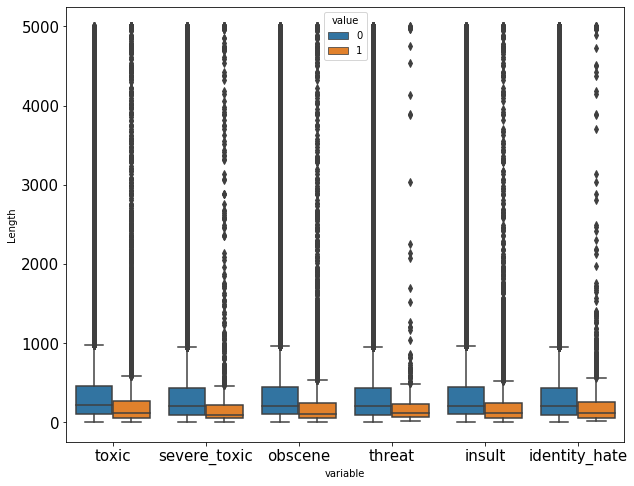

In [124]:
plt.figure(figsize=(10,8))
sns.boxplot(x='variable',y='Length',hue='value',orient='vertical',data=melt_df)

In [23]:
treino_[treino_.Length == treino_.Length.max()]['comment_text'].to_frame().join(ytrain).sum(axis=1)

id
0b2055f13934a41e    3
1091689382892a88    3
171ebb2b785f72bd    1
199912b2d9973a21    4
1c7b06718dcc3b86    3
222aad8a931bcfdf    2
2be09ad5ce9a8a85    0
300b0c81ea94e02d    0
3b0e1b13380cdd7a    5
44096c9bd35a200d    0
47d24c7955d1cc09    4
4c7963eaf9697d35    3
5bed308adc44efcf    4
5e50cf56f160bda3    0
70368dd072aebb42    1
7b6b88051eb69303    1
7c7a4bf4c84fe002    1
7f79fd5eacbe804c    0
8ecc71e2dd4e2fbe    4
95d211c0f481df03    4
96cac8dd8f971c7d    3
97e695cfd71944ed    4
98e4e1f70d28631c    5
a99aff4a8428dfb2    4
bcc6a4fc5f123163    0
c14532e93d456260    1
c7f72686bf613e4e    0
c91d629c6599bb23    0
cbeeca0dd8d32c1a    4
dd0bd64b02c550af    1
e6abb7915c7fd1f1    3
e77118621b13b43f    0
fb3a15d68a7e7ff2    1
02dd3c9a9129c83e    2
8b31f2d7d6025482    2
94f8578325d529ad    4
b0b8f1eaa83616fe    3
c0e076f0011acaa6    4
c8f01ac90c4adc27    4
c7e2a95e8146e108    1
ce2d7821188dd30f    5
f6883b0b85b0dbd7    0
dtype: int64

straight away we can see that most of the max-size comments are labeled positively for at least one label and is not unusual to be in multiple ones.



In [ ]:
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

for col in range(len(y.columns)):
    #print(f'confusion matrix of label {ytest.columns[col]} :\n {confusion_matrix(ytest.iloc[:,col],predictions.iloc[:,col])}')
    for d in range(len(y.columns)):
        if ((col != d) & (cramers_v(y.iloc[:,col],y.iloc[:,d]) > 0.5)): #here we can set a .3 threshold
            print(f'Cramer\'s V entre {y.columns[col]} e {y.columns[d]} : {cramers_v(y.iloc[:,col],y.iloc[:,d])}')

# Now let's dive a bit into text analysis...